# Tutorial 1: Protein DMS analysis using additive G-P maps

This tutorial covers perhaps the simplest application of MAVE-NN: the modeling of DMS data using an additive genotype-phenotype (G-P) map and a global epistasis (GE) measurement process. The code below steps users through this process, and can be used to train models similar to the built-in models `'amyloid_additive_ge'` and `'tdp43_additive_ge'`, which are accessible using `mavenn.load_example_model()`:

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Special imports
import mavenn
from tqdm.keras import TqdmCallback # For better training progress visualization

## Training

First we choose which dataset we wish to model, and we load it as a Pandas dataframe using `mavenn.load_example_dataset()`. We then compute the length of sequences in that dataset, as we will be needed for this quantity for defining the architecture of our model.

In [2]:
# Choose dataset
data_name = 'amyloid'
# data_name = 'tdp43'
print(f"Loading dataset '{data_name}' ")

# Load datset
data_df = mavenn.load_example_dataset(data_name)

# Get and report sequence length
L = len(data_df.loc[0,'x'])
print(f'Sequence length: {L:d} amino acids (+ stops)')

# Preview dataset
data_df

Loading dataset 'amyloid' 
Sequence length: 42 amino acids (+ stops)


,set,dist,y,dy,x
0,training,1,-0.117352,0.387033,KAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
1,training,1,0.352500,0.062247,NAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
2,training,1,-2.818013,1.068137,TAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
3,training,1,0.121805,0.376764,SAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
4,training,1,-2.404340,0.278486,IAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
...,...,...,...,...,...
16061,training,2,-0.151502,0.389821,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVKV
16062,training,2,-1.360708,0.370517,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVLV
16063,training,2,-0.996816,0.346949,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVMV
16064,training,2,-3.238403,0.429008,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVTV


Next we use the built-in function `mavenn.split_dataset()` to split our dataset into two dataframes:

- `trainval_df`: The training and validation data.
- `test_df`: The test data.

This split ensures that our test data stays separate from our training and validation data. Note that `training_df`, previewed below, includes an extra column called `validation` that flags which sequences are reserved for the validation set.

In [3]:
# Split dataset 
trainval_df, test_df = mavenn.split_dataset(data_df)

# Show dataset sizes
print(f'Train + val set size : {len(trainval_df):6,d} observations')
print(f'Test set size        : {len(test_df):6,d} observations')

# Preview trainval_df
trainval_df

Train + val set size : 55,165 observations
Test set size        :  2,831 observations


,validation,dist,y,dy,x
0,False,1,0.032210,0.037438,NNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...
1,False,1,-0.009898,0.038981,TNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...
2,False,1,-0.010471,0.005176,RNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...
3,False,1,0.030803,0.005341,SNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...
4,False,1,-0.054716,0.035752,INSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...
...,...,...,...,...,...
55160,False,2,-0.009706,0.035128,GNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...
55161,True,2,-0.030744,0.029436,GNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...
55162,True,2,-0.086802,0.033174,GNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...
55163,False,2,-0.049587,0.029130,GNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWG...


Now we specify the architecture of the model we wish to train . To do this, we create an instance of the `mavenn.Model` class, called `model`, using the following keyword arguments:

- `L=L` specifies the sequence length.
- `alphabet='protein*'` specifies that the alphabet our sequences are built from consists of 21 characters representing the 20 amino acids plus a stop signal (which is represented by the character `'*'`). Other possible choices for `alphabet` are `'dna'`, `'rna'`, and `'protein'`.
- `gpmap_type='additive'` specifies that we wish to infer an additive G-P map.
- `regression_type='GE'` specifies that our model will have a global epistasis (GE) measurement process. We choose this because our MAVE measurements are continuous real numbers.
- `ge_noise_model_type='SkewedT'` specifies the use of a skewed-t noise model in the GE measurement process. The `'SkewedT'` noise model can accommodate asymmetric noise and is thus more flexible than the default `'Gaussian'` noise model.
- `ge_heteroskedasticity_order=2` specifies that the noise model parameters (the three parameters of the skewed-t distribution) are each modeled using quadratic functions of the predicted measurement $\hat{y}$. This will allow our model of experimental noise to vary with signal intensity.


We then set the training data by calling `model.set_data()`. The keyword argument `'validation_flags'` is used to specify which subset of the data in `trainval_df` will be used for validation (as opposed to stochastic gradient descent).

Next we train the model by calling `model.fit()`. In doing so we specify a number of hyperparameters including the learning rate, the number of epochs, the batch size, whether to use early stopping, and the early stopping patience.  We also set `verbose=False` to limit the amount of user feedback.

Choosing hyperparameters is somewhat of an art, and the particular values used here were found by trial and error. In general users will have to try a number of different values for these and possibly other hyperparameters in order to find ones that work well. We recommend that users choose these hyperparameters in order to maximize the final value for `val_I_var`, the variational information of the trained model on the validation dataset.

In [4]:
# Define model
model = mavenn.Model(L=L,
                     alphabet='protein*',
                     gpmap_type='additive',   
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

# Set training data
model.set_data(x=trainval_df['x'],
               y=trainval_df['y'],
               validation_flags=trainval_df['validation'])

# Train model
model.fit(learning_rate=1e-3,
          epochs=500,
          batch_size=64,
          early_stopping=True,
          early_stopping_patience=25,
          verbose=False,
          callbacks=[TqdmCallback(verbose=0)]);

N = 55,165 observations set as training data.
Using 5.3% for validation.
Data shuffled.
Time to set data: 1.2 sec.


0epoch [00:00, ?epoch/s]

To assess the performance of our final trained model, we compute two different metrics on test data: **variational information** and **predictive information**. Variational information quantifies the performance of the full latent phenotype model, whereas predictive information quantifies the performance of just the G-P map portion of the model. See Tareen et al. (2021) for an expanded discussion of these quantities.

Note that MAVE-NN also estimates the standard errors for these quantities.

In [5]:
# Compute variational information on test data
I_var, dI_var =  model.I_variational(x=test_df['x'], y=test_df['y'])
print(f'test_I_var: {I_var:.3f} +- {dI_var:.3f} bits')

# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df['y'])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

test_I_var: 1.941 +- 0.035 bits
test_I_pred: 2.012 +- 0.023 bits


To save the trained model we call `model.save()`. This records our model in **two separate files**: a pickle file that defines model architecture (extension `'.pickle'`), and an H5 file that records model parameters (extension `'.h5'`).

In [6]:
# Save model to file
model_name = f'{data_name}_additive_ge'
model.save(model_name)

Model saved to these files:
	tdp43_additive_ge.pickle
	tdp43_additive_ge.h5


## Visualization

We now discuss how to visualize the training history, performance, and parameters of a trained model. First we  then load our model using `mavenn.load`:

In [7]:
# Delete model if it is present in memory
try:
    del model
except:
    pass

# Load model from file
model = mavenn.load(model_name)

Model loaded from these files:
	tdp43_additive_ge.pickle
	tdp43_additive_ge.h5


The `model.history` dictionary contains values for multiple model performance metrics, evaluated on both the training data and the validation data, as a function of training epoch. `'loss'` and `'val_loss'` record loss values, while `'I_var'` and `'val_I_var'` record the variational information values. As described in Tareen et al. (2021), these metrics are closely related: variational information is an affine transformation of model likelihood, whereas loss is equal to likelihood plus regularization terms. 

In [8]:
# Show metrics recorded in model.history()
model.history.keys()

dict_keys(['loss', 'I_var', 'val_loss', 'val_I_var'])

Plotting `'I_var'` and `'val_I_var'` versus epoch can often provide insight into the model training process. 

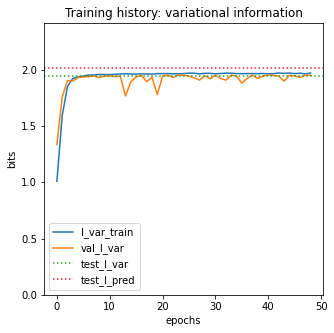

In [9]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Plot I_var_train, the variational information on training data as a function of epoch
ax.plot(model.history['I_var'], 
        label=r'I_var_train')

# Plot I_var_val, the variational information on validation data as a function of epoch
ax.plot(model.history['val_I_var'], 
        label=r'val_I_var')

# Show I_var_test, the variational information of the final model on test data
ax.axhline(I_var, color='C2', linestyle=':', 
           label=r'test_I_var')

# Show I_pred_test, the predictive information of the final model on test data
ax.axhline(I_pred, color='C3', linestyle=':', 
           label=r'test_I_pred')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history: variational information')
ax.set_ylim([0, 1.2*I_pred])
ax.legend()

From this plot we observe a few things:

- `'val_I_var'` quickly converges to its final value, suggesting that model training has likely gone to completion.
- `'I_var'` is noticably higher than `'val_I_var'`, which is indicative of overfitting. But these two quantities largely remain monotonically related to one another, indicating that this overfitting is likely begnin. 
- `'test_I_var'` is quite close to `'test_I_pred'` indicating that the inferred measurement process does a good job of describing the scatter of $y$ about $\hat{y}$.

Users can plot '`loss`' and '`var_loss`' if they like, though the absolute values these quantities are be more difficult to interpret than `'I_var'` and `'val_I_var'`.

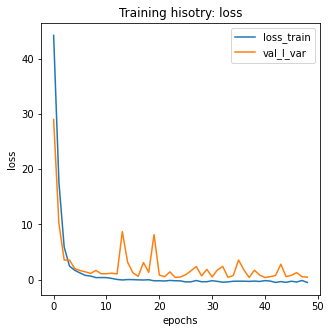

In [10]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Plot loss_train, the loss computed on training data as a function of epoch
ax.plot(model.history['loss'], 
        label=r'loss_train')

# Plot loss_val, the loss computed on validation data as a function of epoch
ax.plot(model.history['val_loss'], 
        label=r'val_I_var')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Training hisotry: loss')
ax.legend()

It is also useful to consider more traditional metrics of model performance. In the context of GE models, a natural choice is $R^2$ between measurements $y$ and model predictions $\hat{y}$:

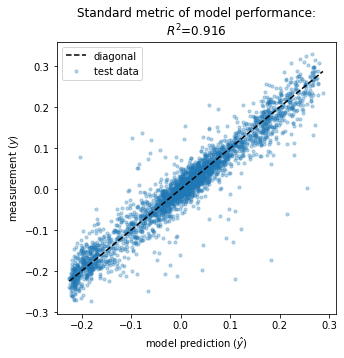

In [11]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Get test data y values
y_test = test_df['y']

# Compute yhat on test data
yhat_test = model.x_to_yhat(test_df['x'])

# Compute R^2 between yhat_test and y_test
Rsq = np.corrcoef(yhat_test.ravel(), test_df['y'])[0, 1]**2

# Plot y_test vs. yhat_test
ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.3, 
           label='test data')

# Style plot
xlim = [min(yhat_test), max(yhat_test)]
ax.plot(xlim, xlim, '--', color='k', label='diagonal', zorder=100)
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'Standard metric of model performance:\n$R^2$={Rsq:.3}');
ax.legend()

Next we visualize the GE measurement process inferred as part of our latent phenotype model. Recall from Tareen et al. (2021) that the measurement process consists of 
  
- A nonlinearity $\hat{y} = g(\phi)$ that deterministically maps the latent phenotype $\phi$ to a prediction $\hat{y}$.
- A noise model $p(y|\hat{y})$ that stochastically maps predictions $\hat{y}$ to measurements $y$.

We can conveniently visualize both of these quantities in a single "global epistatsis plot": 

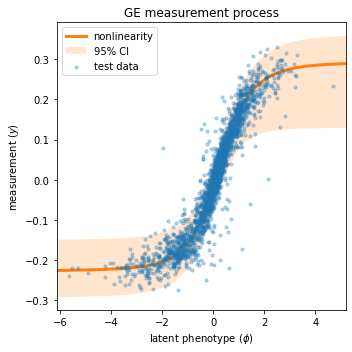

In [12]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Get test data y values
y_test = test_df['y']

# Compute φ on test data
phi_test = model.x_to_phi(test_df['x'])

## Set phi lims and create a grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 95% CI for each yhat
q = [0.025, 0.975]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)


# Plote 95% confidence interval
ax.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1], 
                alpha=0.2, color='C1', lw=0, label='95% CI')

# Plot GE nonlinearity
ax.plot(phi_grid, yhat_grid, 
        linewidth=3, color='C1', label='nonlinearity')

# Plot scatter of φ and y values. 
ax.scatter(phi_test, y_test, 
           color='C0', s=10, alpha=.3, label='test data', zorder=+100)

# Style plot
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GE measurement process')
ax.legend()
fig.tight_layout()

To retrieve the values of our model's G-P map parameters, we use the mmethod `model.get_theta()`. This returns a dictionary:

In [13]:
# Retrieve G-P map parameter dict and view dict keys
theta_dict = model.get_theta(gauge='consensus')
theta_dict.keys()

dict_keys(['L', 'C', 'alphabet', 'theta_0', 'theta_lc', 'theta_lclc', 'theta_mlp', 'logomaker_df'])

It is important to appreciate that G-P maps usually have many non-identifiable directions in parameter space. These are called "gauge freedoms".  Interpreting the values of model parameters requires that we first "pin down" these gauge freedoms by using a clearly specified convension. Specifying `gauge='consensus'` in `model.get_theta()` accomplishes this fixing all the $\theta_{l:c}$ parameters that contribute to the consensus sequence to zero. This convension allows all the other $\theta_{l:c}$ parameters in the additive model to be interpreted as single-mutation effects $\Delta \phi$ away from the consensus sequence. 

Finally, we use `mavenn.heatmap()` to visualize these additive parameters. This function takes a number of keyword arguments, which we summarize here. More information can be found in this function's docstring. 

- `ax=ax`: specifies the axes on which to draw both the heatmap and the colorbar. 
- `values=theta_dict['theta_lc']`: specifies the additive parameters in the form of a `np.array` of size `L`x`C`, where `C` is the alphabet size. 
- `alphabet=theta_dict['alphabet']`: provides a list of characters corresponding to the columns of `values`. 
- `seq=model.x_stats['consensus_seq']`: causes `mavenn.heatmap()` to highlight the characters of a specific sequence of interest. In our case this is the consensus sequence, the additive parameters for which are all fixed to zero. 
- `seq_kwargs={'c':'gray', 's':25}`: provides a keyword dictionary to pass to `ax.scatter()`; this specifies how the characters of the sequence of interest are to be graphically indicated. 
- `cmap='coolwarm'`: specifies the colormap used to represent the values of the additive parameters.
- `cbar=True`: specifies that a colorbar be drawn
- `cmap_size='2%'`: specifies the width of the colorbar relative to the enclosing ax object.
- `cmap_pad=.3`: specifies the spacing between the heatmap and the colorbar
- `ccenter=0`: centers the colormap at zero. 

This function returns two objects: 
- `heatmap_ax` is the axes object on which the heatmap is drawn.
- `cb` is the colorbar object; it's corresponding axes is given by `cb.ax`.

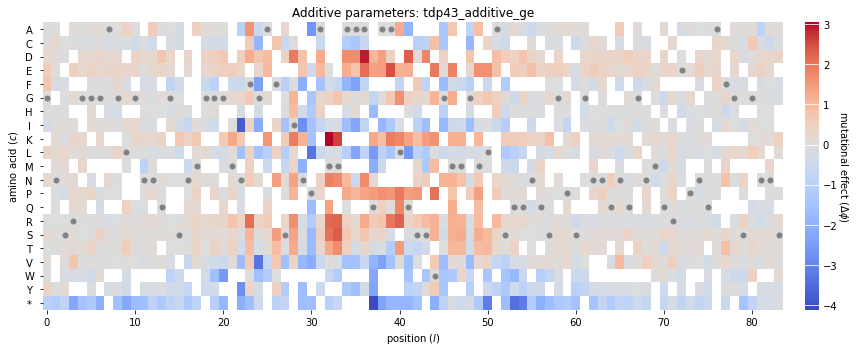

In [14]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(12,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta_dict['theta_lc'],
                                alphabet=theta_dict['alphabet'],
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: {model_name}')

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)

Note that many of the squares in the heatmap are white. These correspond to additive parameters whose values are `NaN`. MAVE-NN sets the values of a feature effect to `NaN` when no variant in the training set exhibits that feature. Such `NaN` parameters are common, even among additive parameters, as DMS libraries often do not contain a comprehensive set of single-amino-acid mutations.

## References

1. Tareen, A., Posfai, A., Ireland, W. T., McCandlish, D. M. & Kinney, J. B. MAVE-NN: learning genotype-phenotype maps from multiplex assays of variant effect. bioRxiv doi:10.1101/2020.07.14.201475 (2020).
1. Seuma, M., Faure, A., Badia, M., Lehner, B. & Bolognesi, B. The genetic landscape for amyloid beta fibril nucleation accurately discriminates familial Alzheimer’s disease mutations. eLife 10, e63364 (2021).
  
  